# Example: Time domain noise removal  

Most sensor data is affected to some extent by noise. In this tutorial, we show you a few examples of noisy signals and describe several techniques to remove noise from the signal. These techniques are also described in the corresponding chapter.

In [1]:
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib notebook

# Set plot styles
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'lines.linewidth': 1})

# Create three different types of signals

We start by generating a clean underlying signal made up of a sinusoid. This will be our 'true' noise-free signal.

We then create three different noisy versions of this signal by adding different types of noise:

- Signal 1 is a typical sinusoid with a bit of random noise.
- Signal 2 has edges in the data i.e. sudden shifts in the data. 
- Signal 3 has outliers i.e. random spurious sensor readings that are very large.

So we now have 3 signals with different characteristics. We will use these to test different filtering techniques.



In [2]:
# Generate data
np.random.seed(42)
n = 500
time = pd.date_range('2023-01-01', periods=n, freq='5min')

# Data 1 - Smoothly changing sinusoidal with noise
# Represents a typical signal you want to filter 
data1 = np.sin(np.arange(n)/5) + np.random.normal(0, 0.1, size=n) 

# Data 2 - Square wave with noise
# Tests filter ability to retain edges
data2 = np.zeros(n)
data2[100:200] = 1 
data2[300:400] = -1
data2 += np.random.normal(0, 0.02, size=n)

# Data 3 - Sinusoidal with outliers
# Tests robustness of filters to outliers
data3 = np.sin(np.arange(n)/5) + np.random.normal(0, 0.1, size=n)
data3[20] += 10
data3[150] -= 9 
data3[200] += 10
data3[350] -= 6 

df = pd.DataFrame({'time': time, 'data1': data1, 'data2': data2, 'data3': data3})

<IPython.core.display.Javascript object>


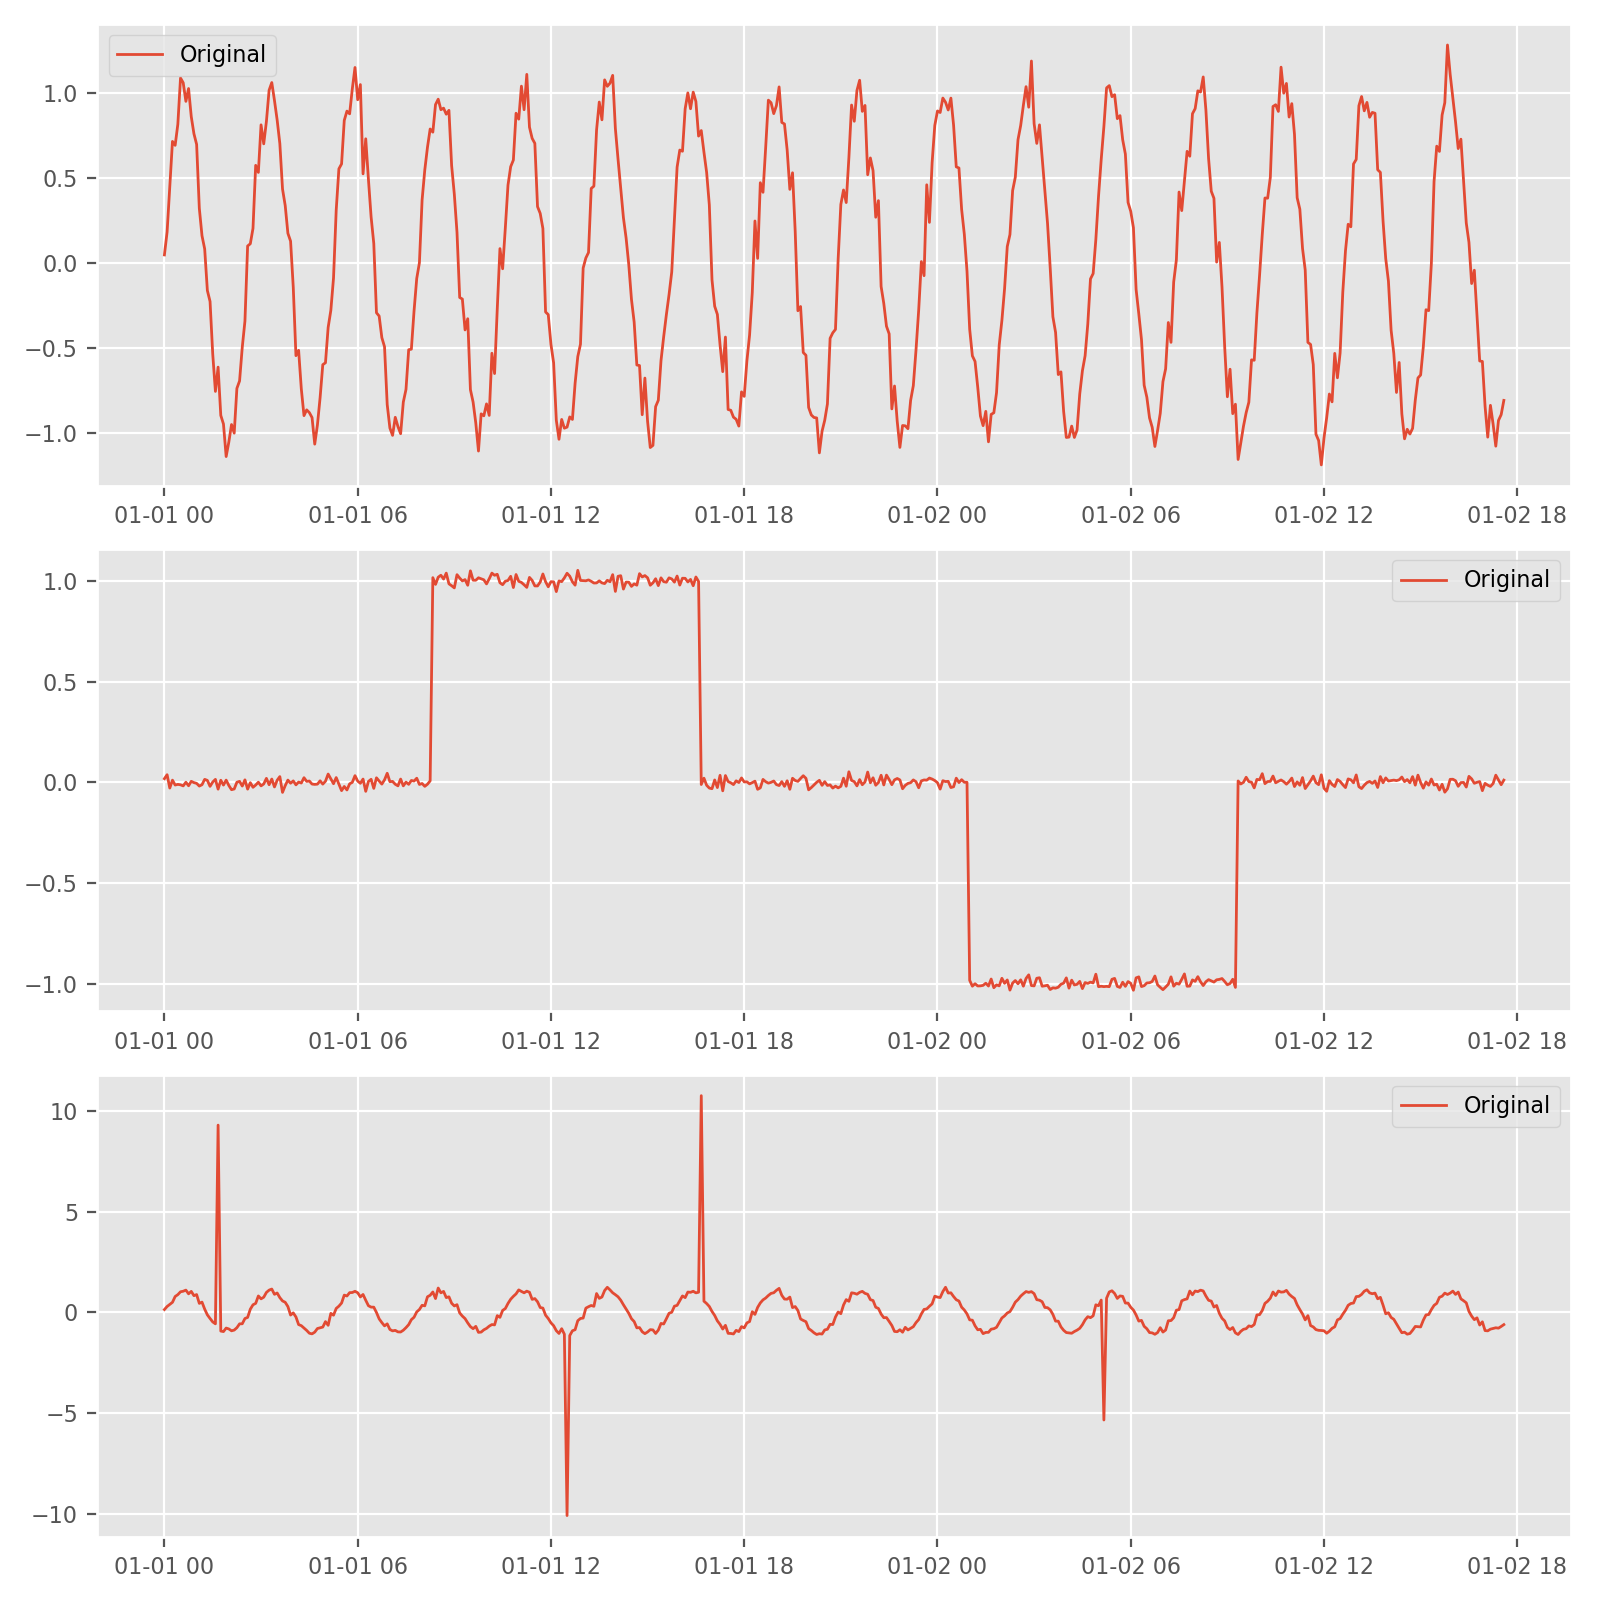

In [3]:
datasets = ['data1', 'data2', 'data3']
fig, axes = plt.subplots(ncols=1, nrows=3)
for i, dataset in enumerate(datasets):
   ax = axes[i]
   ax.plot(df.time, df[dataset], label='Original')
   ax.legend()
plt.tight_layout()
plt.show()

# Moving average 

Moving average smooths data by taking the average over a rolling window. We apply moving average filtering with different window sizes to the 3 generated datasets. As window size increases, more noise is filtered but signal is also smoothed.

We can see the tradeoff between noise filtering and signal distortion for different window sizes.
- Dataset 1 can be smoothed by most window sizes since it has a smooth sinusoidal shape.
- Dataset 2 sensitive to window size choice. Retains its sharp edges best with small window sizes.
- Dataset 3 sensitive to window size choice. Short windows are preferred to avoid being affected by the outlier.

Moving average performs best for Dataset 1. Very sensitive to edges and outliers.


<IPython.core.display.Javascript object>


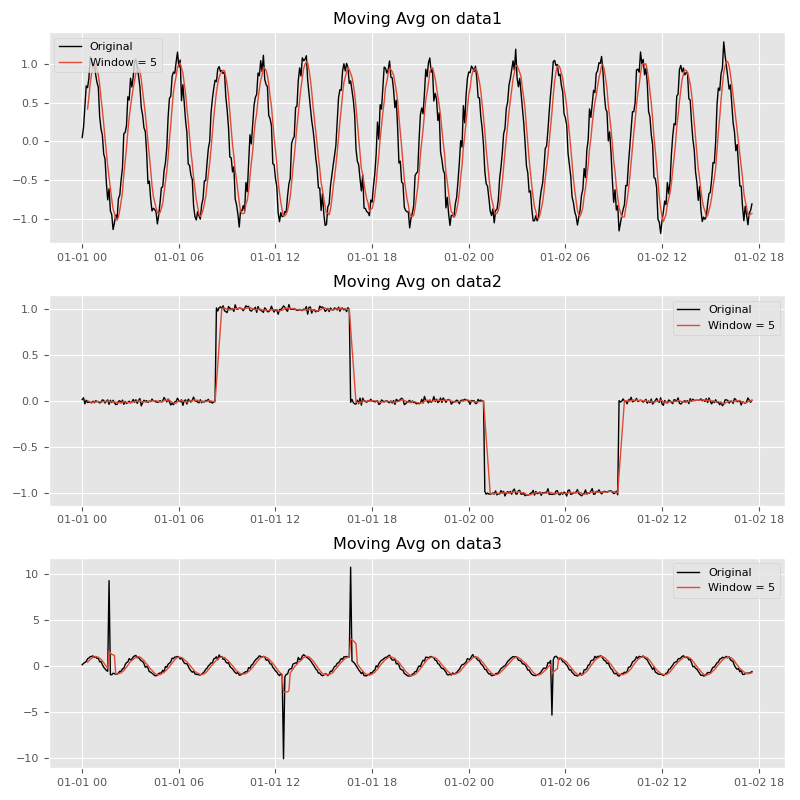

In [13]:
# (a) Moving average
datasets = ['data1', 'data2', 'data3']
windows = [5]
fig, axes = plt.subplots(ncols=1, nrows=3)
for i, dataset in enumerate(datasets):
   ax = axes[i]
   ax.plot(df.time, df[dataset], color='black', label='Original')
   for window in windows:
       avg = df[dataset].rolling(window).mean()  
       ax.plot(df.time, avg, label='Window = {}'.format(window))
   ax.set_title('Moving Avg on {}'.format(dataset))
   ax.legend()
plt.tight_layout()
plt.show()




# Exponential moving average 

Exponential moving average applies weighting factors so recent data has more influence. **Alpha** provides a knob to tune between smoothing and distortion.
- Smaller alpha values preserve signal better but remove less noise.
- Larger alpha values smooth more but distort signal.

Exponential moving average performs best for Dataset 1. It can also be acceptable for Dataset 3 if alpha is tuned properly. Affected by edges and outliers but not as much as Moving Average.

<IPython.core.display.Javascript object>


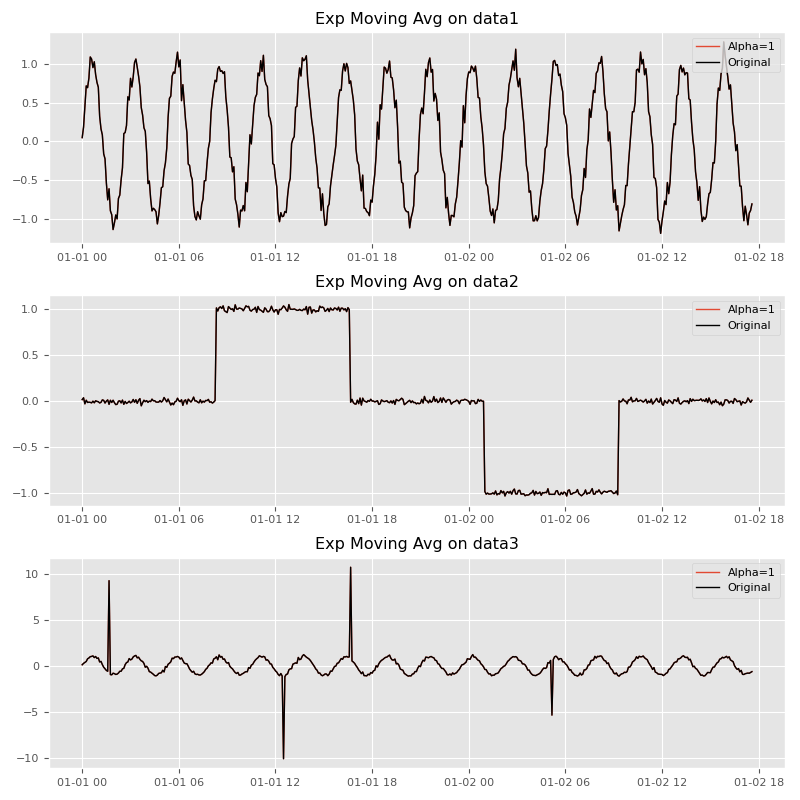

In [15]:
# (b) Exponential Moving Average
alphas = [1]  
fig, axes = plt.subplots(ncols=1, nrows=3)
for i, dataset in enumerate(datasets):
    ax = axes[i]
    for alpha in alphas:
        exp = df[dataset].ewm(alpha=alpha).mean() 
        ax.plot(df.time, exp, label='Alpha={}'.format(alpha))
    ax.plot(df.time, df[dataset], color='black', label='Original')
    ax.set_title('Exp Moving Avg on {}'.format(dataset))
    ax.legend()
plt.tight_layout()
plt.show()



# Median filter

Median filter takes median over rolling window.
- Retains edges better than smoothing filters.
- Performs well when there are outliers

Median filter can make the data less smooth when the data is relatively smooth (like Dataset 1). But is better than moving average/exponential moving average at preserving edges and dealing with outliers. Larger windows remove more noise at expense of distortion.


<IPython.core.display.Javascript object>


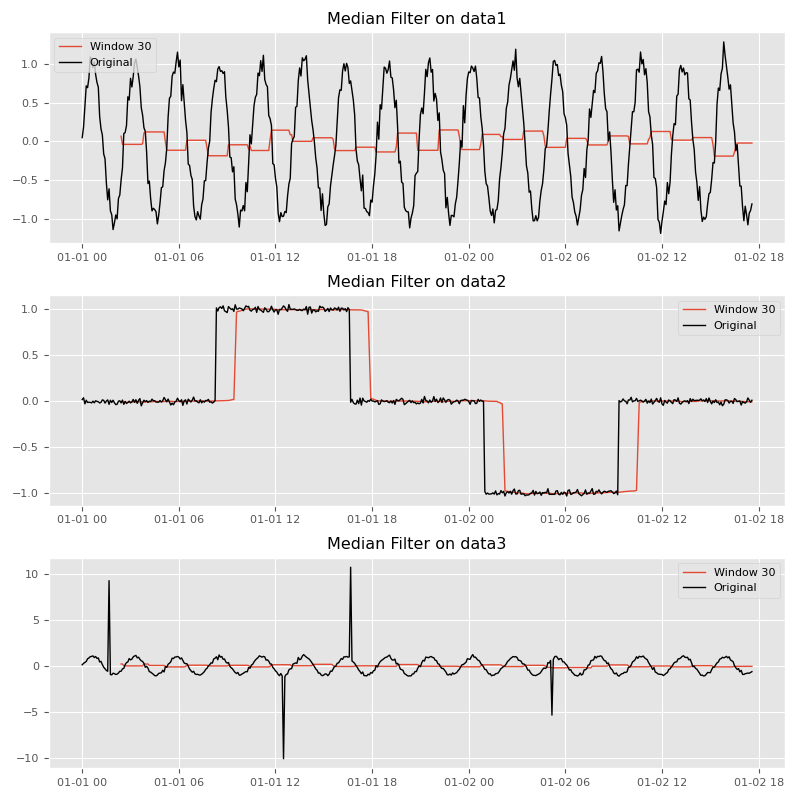

In [18]:
# (c) Median Filter
windows = [30]
fig, axes = plt.subplots(ncols=1, nrows=3)
for i, dataset in enumerate(datasets):
    ax = axes[i]
    for window in windows:
        roll_med = df[dataset].rolling(window).median()
        ax.plot(df.time, roll_med, label='Window {}'.format(window))
    ax.plot(df.time, df[dataset], color='black', label='Original') 
    ax.set_title('Median Filter on {}'.format(dataset))
    ax.legend()
plt.tight_layout()
plt.show()

# Comparison of moving avg, exponential and median filters

Compares moving average, exponential, and median filters on each dataset. Allows us to see the unique effects of each filter side-by-side.  
- Moving average smooths, 
- exponential preserves peaks, 
- median retains edges and handles outliers.

It is generally a useful practice to compare filters before selecting the best one for a dataset.

<IPython.core.display.Javascript object>


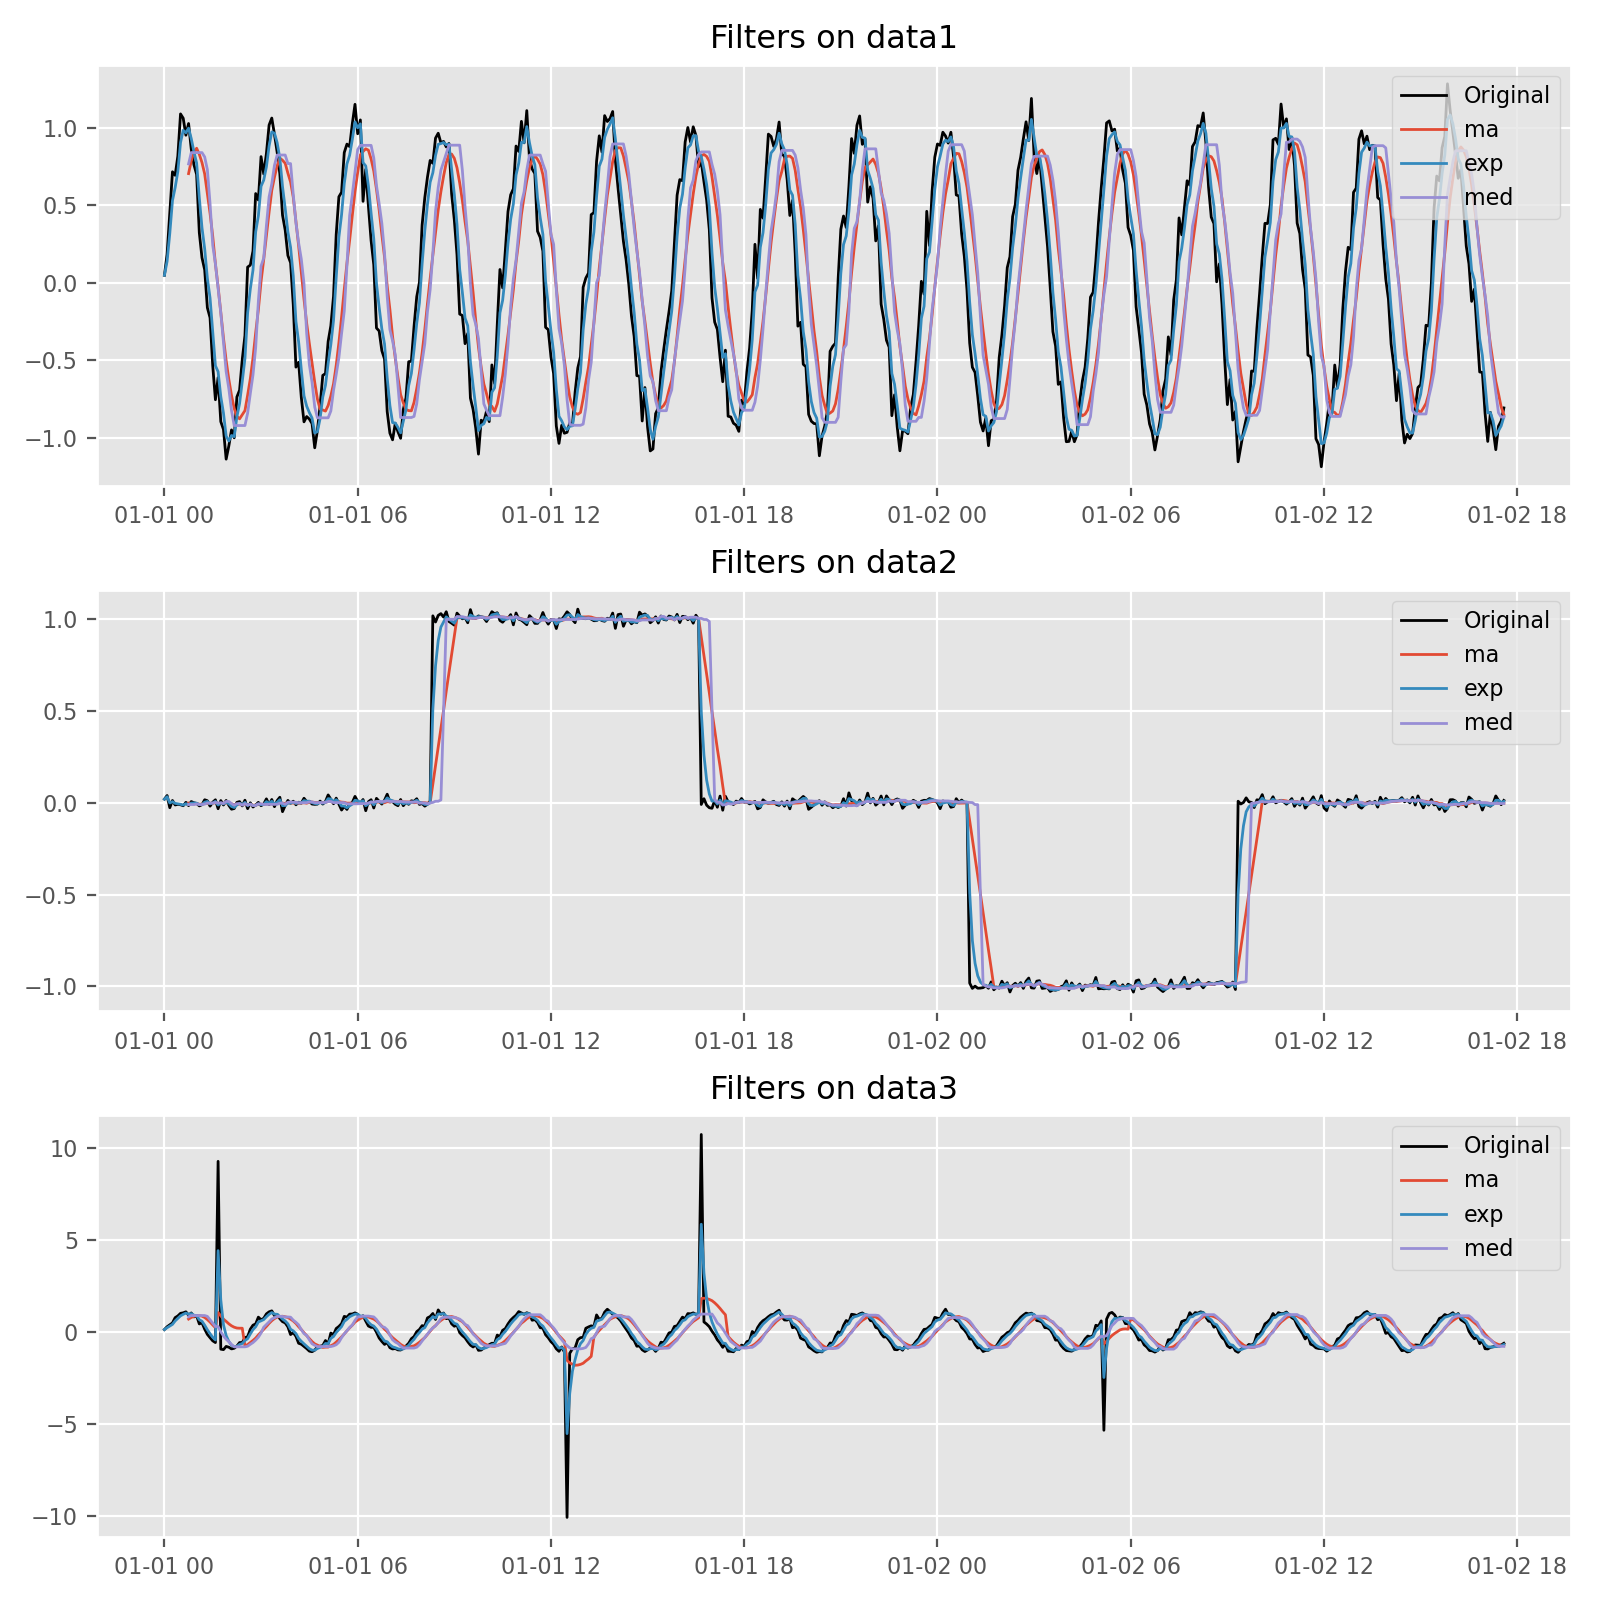

In [7]:
# (d) Compare all filters on each dataset
datasets = ['data1', 'data2', 'data3']
filters = ['ma', 'exp', 'med'] 
params = [{'window': 10}, {'alpha': 0.5}, {'window': 10}]

fig, axes = plt.subplots(ncols=1, nrows=3)

for i, dataset in enumerate(datasets):
    
    ax = axes[i]
    ax.plot(df.time, df[dataset], color='black', label='Original')
    
    for filter, param in zip(filters, params):
        if filter=='ma':
            y = df[dataset].rolling(**param).mean()
        elif filter=='exp':
            y = df[dataset].ewm(**param).mean()
        else:
            y = df[dataset].rolling(**param).median()
            
        ax.plot(df.time, y, label=filter)
        
    ax.set_title('Filters on {}'.format(dataset)) 
    ax.legend()
    
plt.tight_layout()
plt.show()